In [1]:
import torch
import numpy as np
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
import torch.nn as nn

C:\Users\akank\AppData\Local\Programs\Python\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')

CUDA is not available.  Training on CPU ...


In [3]:
# number of subprocesses to use for data loading
num_workers = 0

# how many samples per batch to load
batch_size = 20

# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

# choose the training and test datasets
train_data = datasets.CIFAR10('data', train=True,
                              download=True, transform=transform)
test_data = datasets.CIFAR10('data', train=False,
                             download=True, transform=transform)

# obtain training indices that will be used for validation
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

# define samplers for obtaining training and validation batches
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

# prepare data loaders (combine dataset and sampler)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=train_sampler, num_workers=num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, sampler=valid_sampler, num_workers=num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

# specify the image classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer',
           'dog', 'frog', 'horse', 'ship', 'truck']

100%|██████████| 170498071/170498071 [08:10<00:00, 347482.70it/s]


Extracting data\cifar-10-python.tar.gz to data
Files already downloaded and verified


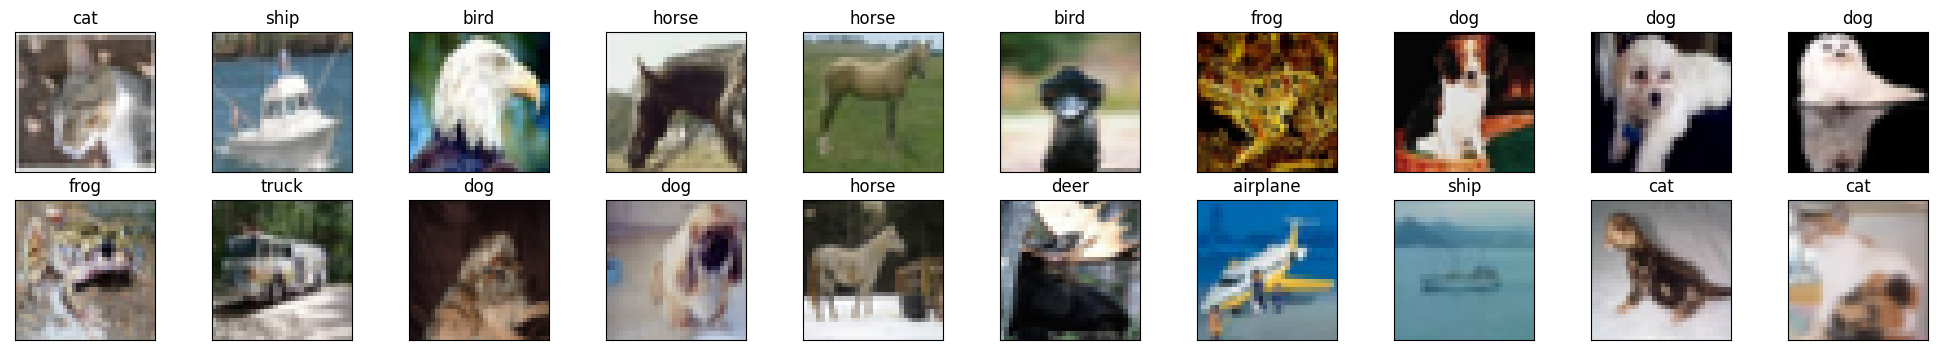

In [4]:
import matplotlib.pyplot as plt
%matplotlib inline

# helper function to un-normalize and display an image
def imshow(img):
    # unnormalize
    img = img / 2 + 0.5
    # convert from Tensor image
    plt.imshow(np.transpose(img, (1, 2, 0)))

# obtain one batch of training images
dataiter = iter(train_loader)
images, labels = dataiter.next()
# convert images to numpy for display
images = images.numpy()

# plot the images in the batch, along with the corresponding labels
fig = plt.figure(figsize=(25, 4))
# display 20 images
for idx in np.arange(20):
  ax = fig.add_subplot(2, int(20/2), idx+1, xticks=[], yticks=[])
  imshow(images[idx])
  ax.set_title(classes[labels[idx]])  

In [5]:
""" 
      PART-A : CONV-POOL-CONV-POOL-CONV-POOL-FC
"""

class NetA(nn.Module):
  def __init__(self):
    super().__init__()
    self.network=nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1),
        nn.MaxPool2d(3, stride=1),
        nn.Conv2d(32,64,kernel_size=3, stride=1),
        nn.MaxPool2d(3, stride=1),
        nn.Conv2d(64,128,kernel_size=3, stride=1),
        nn.MaxPool2d(3, stride=1),
        nn.Flatten(),
        nn.Linear(51200,10))
        
  def forward(self, x):
    return self.network(x)

#Creating a CNN architecture
modelA = NetA()
print(modelA)

if train_on_gpu:
  modelA.cuda()

NetA(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=51200, out_features=10, bias=True)
  )
)


In [6]:
import torch.optim as optim

# specify loss function
criterion = nn.CrossEntropyLoss()

# specify optimizer
optimizerA = optim.SGD(modelA.parameters(), lr=.01)

# number of epochs to train the model
n_epochs = 10

#List to store loss to visualize
train_losslistA = []
# track change in validation loss
valid_loss_minA = np.Inf

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_lossA = 0.0
    valid_lossA = 0.0
    
    ###################
    # train the model #
    ###################
    modelA.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizerA.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modelA(data)
        # calculate the batch loss
        lossA = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        lossA.backward()
        # perform a single optimization step (parameter update)
        optimizerA.step()
        # update training loss
        train_lossA += lossA.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    modelA.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modelA(data)
        # calculate the batch loss
        lossA = criterion(output, target)
        # update average validation loss 
        valid_lossA += lossA.item()*data.size(0)
    
    # calculate average losses
    train_lossA = train_lossA/len(train_loader.dataset)
    valid_lossA = valid_lossA/len(valid_loader.dataset)
    train_losslistA.append(train_lossA)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_lossA, valid_lossA))

    # save model if validation loss has decreased
    if valid_lossA <= valid_loss_minA:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_minA,
        valid_lossA))
        torch.save(modelA.state_dict(), 'model_cifar.pt')
        valid_loss_minA = valid_lossA

Epoch: 1 	Training Loss: 1.163150 	Validation Loss: 0.250418
Epoch: 2 	Training Loss: 0.934312 	Validation Loss: 0.238831
Epoch: 3 	Training Loss: 0.857507 	Validation Loss: 0.221316
Epoch: 4 	Training Loss: 0.811854 	Validation Loss: 0.205390
Epoch: 5 	Training Loss: 0.770790 	Validation Loss: 0.214200
Epoch: 6 	Training Loss: 0.737296 	Validation Loss: 0.196623
Epoch: 7 	Training Loss: 0.703262 	Validation Loss: 0.209357
Epoch: 8 	Training Loss: 0.676174 	Validation Loss: 0.197318
Epoch: 9 	Training Loss: 0.646096 	Validation Loss: 0.199880
Epoch: 10 	Training Loss: 0.618406 	Validation Loss: 0.207130


"\n    # save model if validation loss has decreased\n    if valid_lossA <= valid_loss_minA:\n        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(\n        valid_loss_minA,\n        valid_lossA))\n        torch.save(modelA.state_dict(), 'model_cifar.pt')\n        valid_loss_minA = valid_lossA\n"

In [7]:
# track test loss
test_lossA = 0.0
class_correctA = list(0. for i in range(10))
class_totalA = list(0. for i in range(10))

modelA.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = modelA(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_lossA += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correctA[label] += correct[i].item()
        class_totalA[label] += 1

# average test loss
test_lossA = test_lossA/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_lossA))

for i in range(10):
    if class_totalA[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correctA[i] / class_totalA[i],
            np.sum(class_correctA[i]), np.sum(class_totalA[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correctA) / np.sum(class_totalA),
    np.sum(class_correctA), np.sum(class_totalA)))

Test Loss: 1.052526

Test Accuracy of airplane: 63% (637/1000)
Test Accuracy of automobile: 86% (860/1000)
Test Accuracy of  bird: 45% (456/1000)
Test Accuracy of   cat: 47% (478/1000)
Test Accuracy of  deer: 57% (572/1000)
Test Accuracy of   dog: 54% (545/1000)
Test Accuracy of  frog: 82% (827/1000)
Test Accuracy of horse: 67% (677/1000)
Test Accuracy of  ship: 84% (846/1000)
Test Accuracy of truck: 71% (713/1000)

Test Accuracy (Overall): 66% (6611/10000)


In [8]:
""" 
    PART-B: CONV-CONV-POOL-CONV-CONV-POOL-FC
"""

class Net(nn.Module):
  def __init__(self):
    super().__init__()
    self.network=nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1),
        nn.Conv2d(32,64,kernel_size=3, stride=1),
        nn.MaxPool2d(3, stride=1),
        nn.Conv2d(64,128,kernel_size=3, stride=1),
        nn.Conv2d(128,256,kernel_size=3, stride=1),
        nn.MaxPool2d(3, stride=1),
        nn.Flatten(),
        nn.Linear(102400, 10)
        )
        
  
  def forward(self, x):
    return self.network(x)

#Creating a CNN architecture
modelB = Net()
print(modelB)

if train_on_gpu:
  modelB.cuda()

Net(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (2): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=102400, out_features=10, bias=True)
  )
)


In [9]:
# specify optimizer
optimizerB = optim.SGD(modelB.parameters(), lr=.01)

# number of epochs to train the model
n_epochs = 10

#List to store loss to visualize
train_losslistB = []
valid_loss_minB = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_lossB = 0.0
    valid_lossB = 0.0
    
    ###################
    # train the model #
    ###################
    modelB.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizerB.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modelB(data)
        # calculate the batch loss
        lossB = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        lossB.backward()
        # perform a single optimization step (parameter update)
        optimizerB.step()
        # update training loss
        train_lossB += lossB.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    modelB.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modelB(data)
        # calculate the batch loss
        lossB = criterion(output, target)
        # update average validation loss 
        valid_lossB += lossB.item()*data.size(0)
    
    # calculate average losses
    train_lossB = train_lossB/len(train_loader.dataset)
    valid_lossB = valid_lossB/len(valid_loader.dataset)
    train_losslistB.append(train_lossB)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_lossB, valid_lossB))
        
    # save model if validation loss has decreased
    if valid_lossB <= valid_loss_minB:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_minB,
        valid_lossB))
        torch.save(modelB.state_dict(), 'model_cifar.pt')
        valid_loss_minB = valid_lossB

Epoch: 1 	Training Loss: 1.155493 	Validation Loss: 0.253635
Epoch: 2 	Training Loss: 0.916485 	Validation Loss: 0.222744
Epoch: 3 	Training Loss: 0.836632 	Validation Loss: 0.216842
Epoch: 4 	Training Loss: 0.782524 	Validation Loss: 0.208478
Epoch: 5 	Training Loss: 0.738725 	Validation Loss: 0.203337
Epoch: 6 	Training Loss: 0.696000 	Validation Loss: 0.197093
Epoch: 7 	Training Loss: 0.657934 	Validation Loss: 0.202344
Epoch: 8 	Training Loss: 0.619264 	Validation Loss: 0.208906
Epoch: 9 	Training Loss: 0.580340 	Validation Loss: 0.208559
Epoch: 10 	Training Loss: 0.543388 	Validation Loss: 0.211013


"\n    # save model if validation loss has decreased\n    if valid_lossB <= valid_loss_minB:\n        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(\n        valid_loss_minB,\n        valid_lossB))\n        torch.save(modelB.state_dict(), 'model_cifar.pt')\n        valid_loss_minB = valid_lossB\n"

In [10]:
# track test loss
test_lossB = 0.0
class_correctB = list(0. for i in range(10))
class_totalB = list(0. for i in range(10))

modelB.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = modelB(data)
    # calculate the batch loss
    lossB = criterion(output, target)
    # update test loss 
    test_lossB += lossB.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correctB[label] += correct[i].item()
        class_totalB[label] += 1

# average test loss
test_lossB = test_lossB/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_lossB))

for i in range(10):
    if class_totalB[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correctB[i] / class_totalB[i],
            np.sum(class_correctB[i]), np.sum(class_totalB[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correctB) / np.sum(class_totalB),
    np.sum(class_correctB), np.sum(class_totalB)))

Test Loss: 1.015917

Test Accuracy of airplane: 61% (617/1000)
Test Accuracy of automobile: 74% (747/1000)
Test Accuracy of  bird: 53% (530/1000)
Test Accuracy of   cat: 54% (540/1000)
Test Accuracy of  deer: 58% (589/1000)
Test Accuracy of   dog: 51% (517/1000)
Test Accuracy of  frog: 85% (856/1000)
Test Accuracy of horse: 71% (718/1000)
Test Accuracy of  ship: 83% (830/1000)
Test Accuracy of truck: 78% (784/1000)

Test Accuracy (Overall): 67% (6728/10000)


In [11]:
import torch.nn as nn

""" 
      PART-C: CONV-POOL-CONV-POOL-CONV-POOL-FC-FC
"""


# define the CNN architecture
class NetC(nn.Module):
  def __init__(self):
    super().__init__()
    self.network=nn.Sequential(
        nn.Conv2d(3, 32, kernel_size=3, stride=1),
        nn.MaxPool2d(3, stride=1),
        nn.Conv2d(32, 64, kernel_size=3, stride=1),
        nn.MaxPool2d(3, stride=1),
        nn.Conv2d(64, 128, kernel_size=3, stride=1),
        nn.MaxPool2d(3, stride=1),
        nn.Flatten(),
        nn.Linear(51200, 10),
        nn.Flatten(),
        nn.Linear(10, 25600))
  
  def forward(self, x):
    return self.network(x)

#Creating a CNN architecture
modelC = NetC()
print(modelC)

if train_on_gpu:
  modelC.cuda()

NetC(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1))
    (1): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (5): MaxPool2d(kernel_size=3, stride=1, padding=0, dilation=1, ceil_mode=False)
    (6): Flatten(start_dim=1, end_dim=-1)
    (7): Linear(in_features=51200, out_features=10, bias=True)
    (8): Flatten(start_dim=1, end_dim=-1)
    (9): Linear(in_features=10, out_features=25600, bias=True)
  )
)


In [12]:
# specify optimizer
optimizerC = optim.SGD(modelC.parameters(), lr=.01)

# number of epochs to train the model
n_epochs = 10

#List to store loss to visualize
train_losslistC = []
valid_loss_minC = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_lossC = 0.0
    valid_lossC = 0.0
    
    ###################
    # train the model #
    ###################
    modelC.train()
    for data, target in train_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizerC.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modelC(data)
        # calculate the batch loss
        lossC = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        lossC.backward()
        # perform a single optimization step (parameter update)
        optimizerC.step()
        # update training loss
        train_lossC += lossC.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    modelC.eval()
    for data, target in valid_loader:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = modelC(data)
        # calculate the batch loss
        lossC = criterion(output, target)
        # update average validation loss 
        valid_lossC += lossC.item()*data.size(0)
    
    # calculate average losses
    train_lossC = train_lossC/len(train_loader.dataset)
    valid_lossC = valid_lossC/len(valid_loader.dataset)
    train_losslistC.append(train_lossC)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_lossC, valid_lossC))
        
    # save model if validation loss has decreased
    if valid_lossC <= valid_loss_minC:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_minC,
        valid_lossC))
        torch.save(modelC.state_dict(), 'model_cifar.pt')
        valid_loss_minC = valid_lossC

Epoch: 1 	Training Loss: 1.437564 	Validation Loss: 0.269029
Validation loss decreased (inf --> 0.269029).  Saving model ...
Epoch: 2 	Training Loss: 0.998575 	Validation Loss: 0.234794
Validation loss decreased (0.269029 --> 0.234794).  Saving model ...
Epoch: 3 	Training Loss: 0.901391 	Validation Loss: 0.234114
Validation loss decreased (0.234794 --> 0.234114).  Saving model ...
Epoch: 4 	Training Loss: 0.845825 	Validation Loss: 0.208939
Validation loss decreased (0.234114 --> 0.208939).  Saving model ...
Epoch: 5 	Training Loss: 0.802751 	Validation Loss: 0.218956
Epoch: 6 	Training Loss: 0.772292 	Validation Loss: 0.206179
Validation loss decreased (0.208939 --> 0.206179).  Saving model ...
Epoch: 7 	Training Loss: 0.739164 	Validation Loss: 0.205776
Validation loss decreased (0.206179 --> 0.205776).  Saving model ...
Epoch: 8 	Training Loss: 0.710734 	Validation Loss: 0.193656
Validation loss decreased (0.205776 --> 0.193656).  Saving model ...
Epoch: 9 	Training Loss: 0.682539 

In [15]:
# track test loss
test_lossC = 0.0
class_correctC = list(0. for i in range(10))
class_totalC = list(0. for i in range(10))

modelC.eval()
# iterate over test data
for data, target in test_loader:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = modelC(data)
    # calculate the batch loss
    lossC = criterion(output, target)
    # update test loss 
    test_lossC += lossC.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correctC[label] += correct[i].item()
        class_totalC[label] += 1

# average test loss
test_lossC = test_lossC/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_lossC))

for i in range(10):
    if class_totalC[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correctC[i] / class_totalC[i],
            np.sum(class_correctC[i]), np.sum(class_totalC[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correctC) / np.sum(class_totalC),
    np.sum(class_correctC), np.sum(class_totalC)))

Test Loss: 1.011180

Test Accuracy of airplane: 73% (736/1000)
Test Accuracy of automobile: 74% (741/1000)
Test Accuracy of  bird: 43% (434/1000)
Test Accuracy of   cat: 46% (464/1000)
Test Accuracy of  deer: 58% (588/1000)
Test Accuracy of   dog: 61% (617/1000)
Test Accuracy of  frog: 86% (862/1000)
Test Accuracy of horse: 62% (620/1000)
Test Accuracy of  ship: 75% (755/1000)
Test Accuracy of truck: 77% (773/1000)

Test Accuracy (Overall): 65% (6590/10000)


Reference: https://shonit2096.medium.com/cnn-on-cifar10-data-set-using-pytorch-34be87e09844